<a href="https://colab.research.google.com/github/ArchitGupta16/Stock-Price-Forecasting/blob/main/LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting multiple Indian stocks using a single LSTM model

![a4b8647a-09e8-4576-95de-e622dcc38d72_1280x720.jpg](attachment:9f16dd74-6217-4511-a371-6568d2ad7d45.jpg)

#### In this notebook, we delve into the world of time series data, which consists of data points ordered chronologically. Time series data is ubiquitous and holds great importance for data analysts and data scientists alike.

#### Our focus will be on exploring stock market data, specifically from leading Indian companies. Through this exploration, we aim to gain insights into various facets of these stocks using data visualization techniques facilitated by Seaborn and Matplotlib.

#### Throughout this notebook, we'll examine different methods for assessing the risk associated with a stock based on its historical performance. Additionally, we'll embark on a journey to predict future stock prices using a Long Short-Term Memory (LSTM) approach.

### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import sklearn
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

### Defining the mean absolute percent error metric

In [ ]:
def mean_absolute_percent_error(y_true,y_pred):
    total = np.sum(np.divide(np.array(y_pred),np.array(y_true)))
    return 100*np.abs((len(y_true))-total)/len(y_true)

### Importing the stock data

##### We will just use the closing price to predict and forecast the same

In [ ]:
stock_list = ["CIPLA", "BPCL", "GAIL", "IOC", "RELIANCE", "NTPC"]
df = {}
for stock in stock_list:
    df[stock] = pd.read_csv(r"/content/" + stock + ".csv", index_col="Date", parse_dates=["Date"])
    df[stock] = df[stock]["Close"]

### Exploaring the data

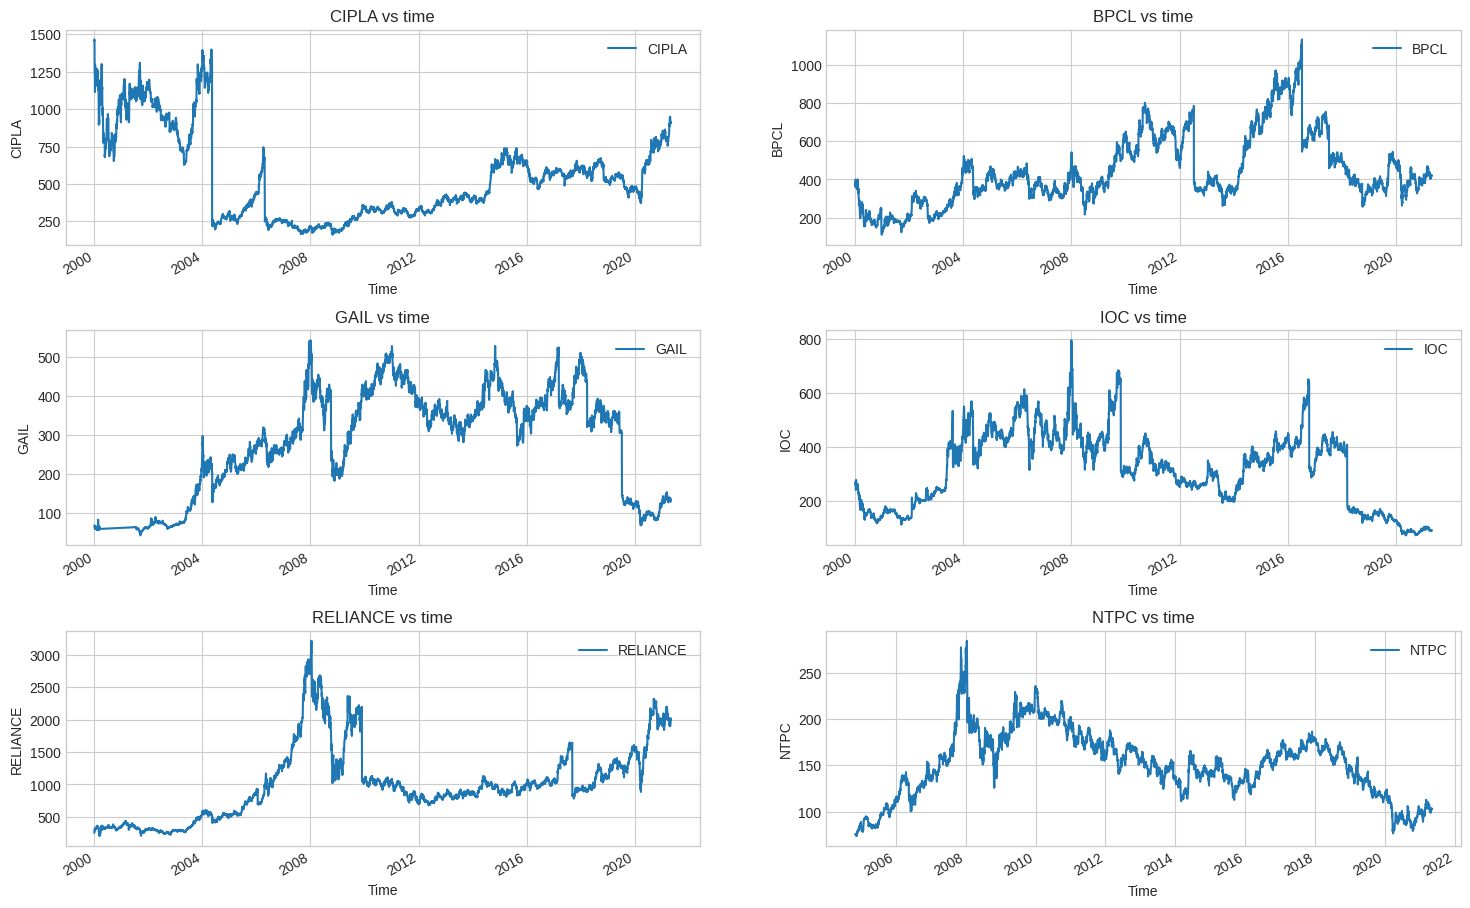

In [ ]:
fig, ax = plt.subplots(8,1, figsize=(18,12))
i=1
for stock in stock_list:
    plt.subplot(3,2,i)
    df[stock].plot(label=stock)
    plt.xlabel('Time')
    plt.ylabel(stock)
    plt.title(stock+' vs time')
    plt.legend()
    i = i+1
plt.subplots_adjust(hspace=0.4)

### Measuring the daily returns of the stocks

#### We will measure the daily change in the stock price and check what distribution it follows

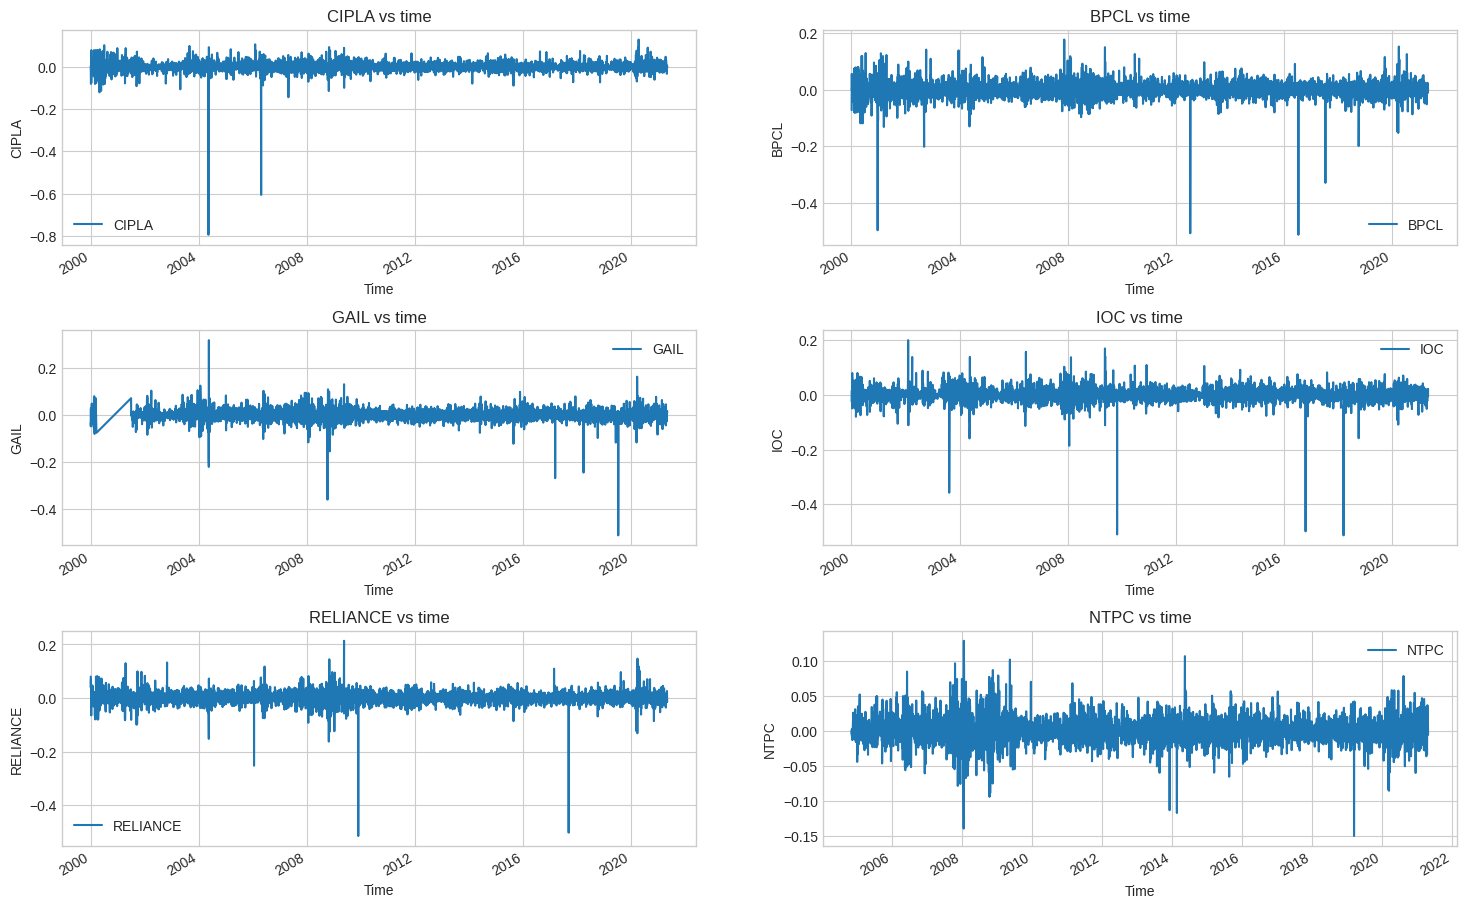

In [ ]:
fig, ax = plt.subplots(8,1, figsize=(18,12))
i=1
for stock in stock_list:
    plt.subplot(3,2,i)
    temp = df[stock].pct_change()
    temp.plot(label=stock)
    plt.xlabel('Time')
    plt.ylabel(stock)
    plt.title(stock+' vs time')
    plt.legend()
    i = i+1
plt.subplots_adjust(hspace=0.4)

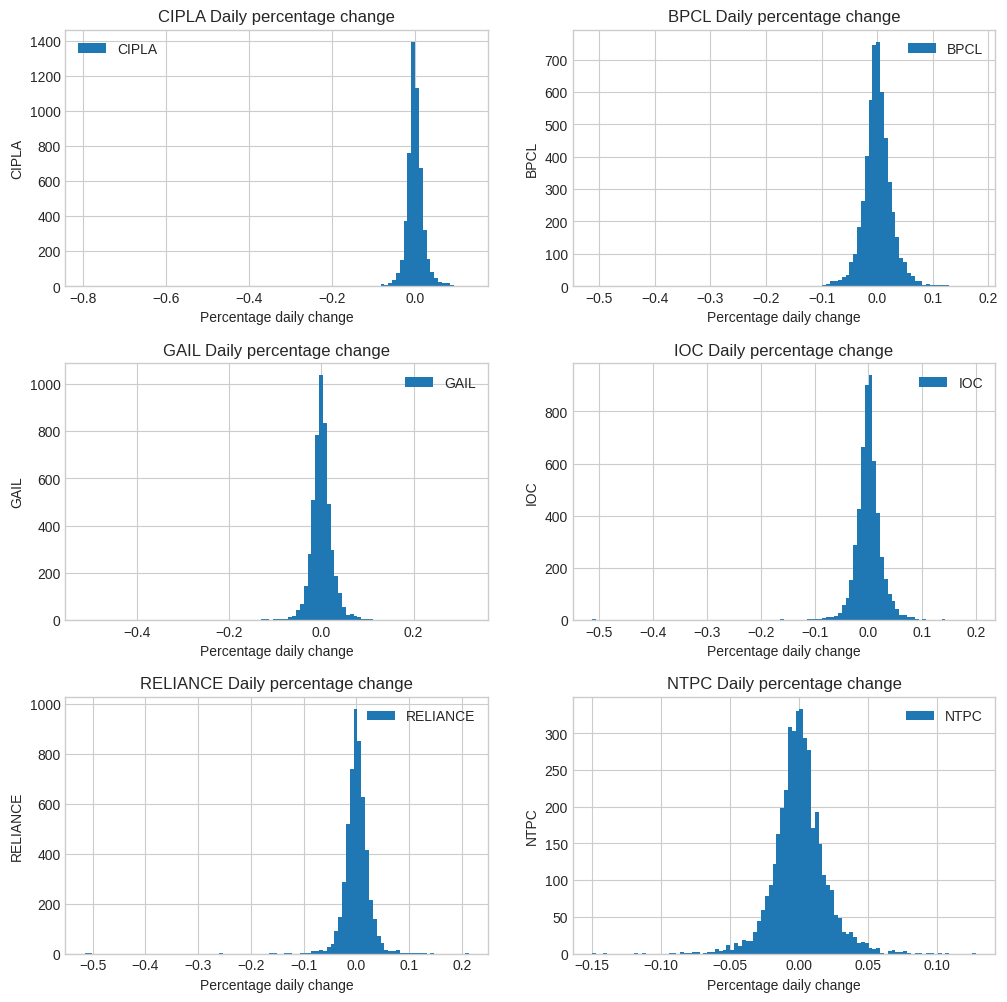

In [ ]:
fig, ax = plt.subplots(8,1, figsize=(12,12))
i=1
for stock in stock_list:
    plt.subplot(3,2,i)
    temp = df[stock].pct_change()
    temp.hist(label=stock, bins = 100)
    plt.xlabel('Percentage daily change')
    plt.ylabel(stock)
    plt.title(stock+' Daily percentage change')
    plt.legend()
    i = i+1
plt.subplots_adjust(hspace=0.3)

### Finding correlation between the stock prices

#### Checking for correlation between stocks can be helpful, if they are correlated then it would be easier for our model to predict their prices. If they are not correlated then our model would get a diverse exposure to the stock data and it would help us in diversification and mitigating risk.

In [ ]:
combined_df = pd.DataFrame()
for stock in stock_list:
    combined_df[stock] = df[stock]

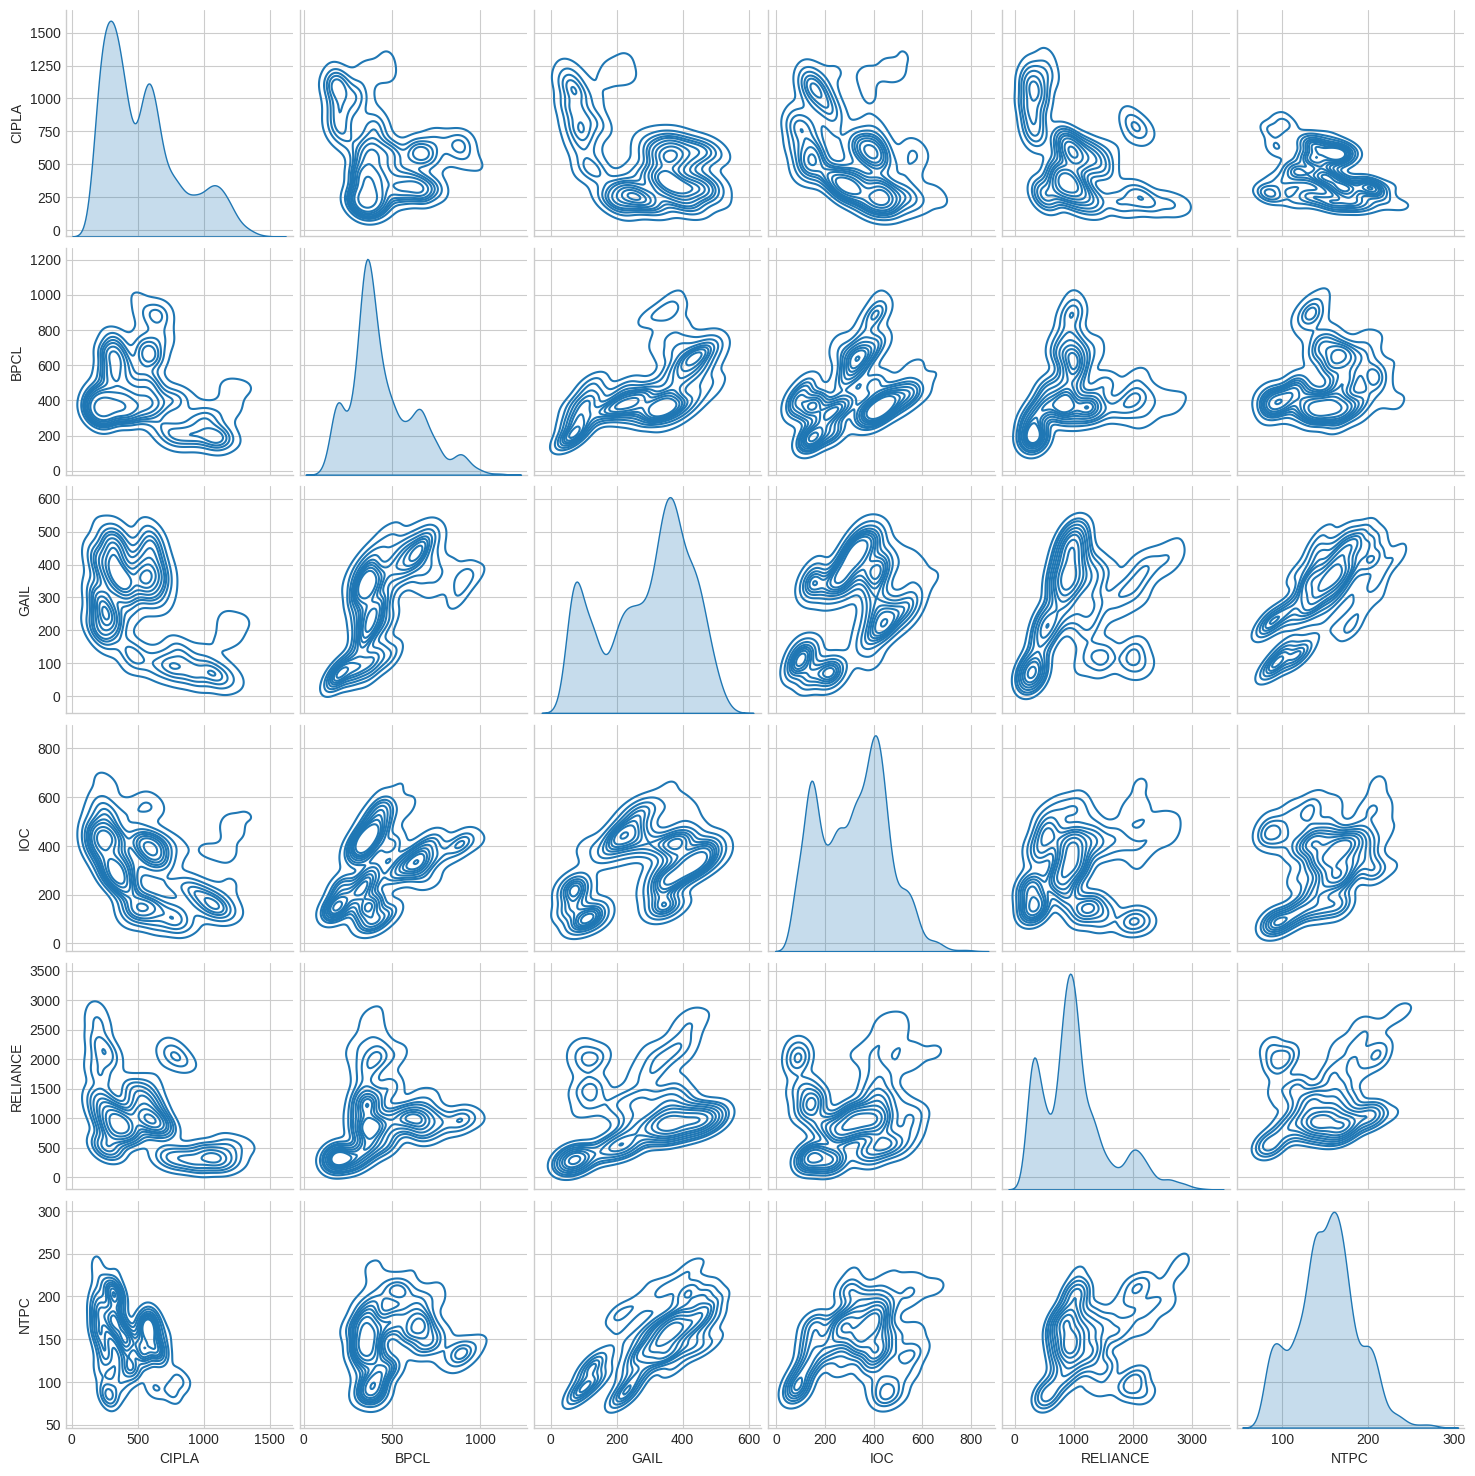

In [ ]:
plot = sns.pairplot(combined_df, kind = 'kde')
plt.show()

#### The stocks do not seem to be directly correlated as one can see form the pair plot, that means the data has variety. We can also check for the value of the correlation coefficient.

[]

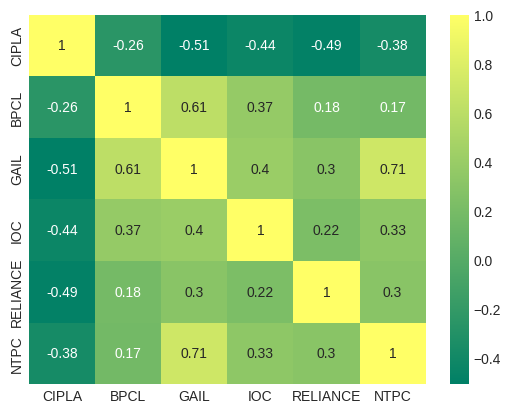

In [ ]:
sns.heatmap(combined_df.corr(), cmap = 'summer', annot = True)
plt.plot()

### Splitting the data for training and testing



In [ ]:
# startdate = dt.datetime.strptime('2018-01-01', "%Y-%m-%d").date()

training_df = {}
testing_df = {}
for stock, data in df.items():
    training_df[stock] = data.loc[data.index < '2018-01-01']
    testing_df[stock]  = data.loc[data.index >= '2018-01-01']

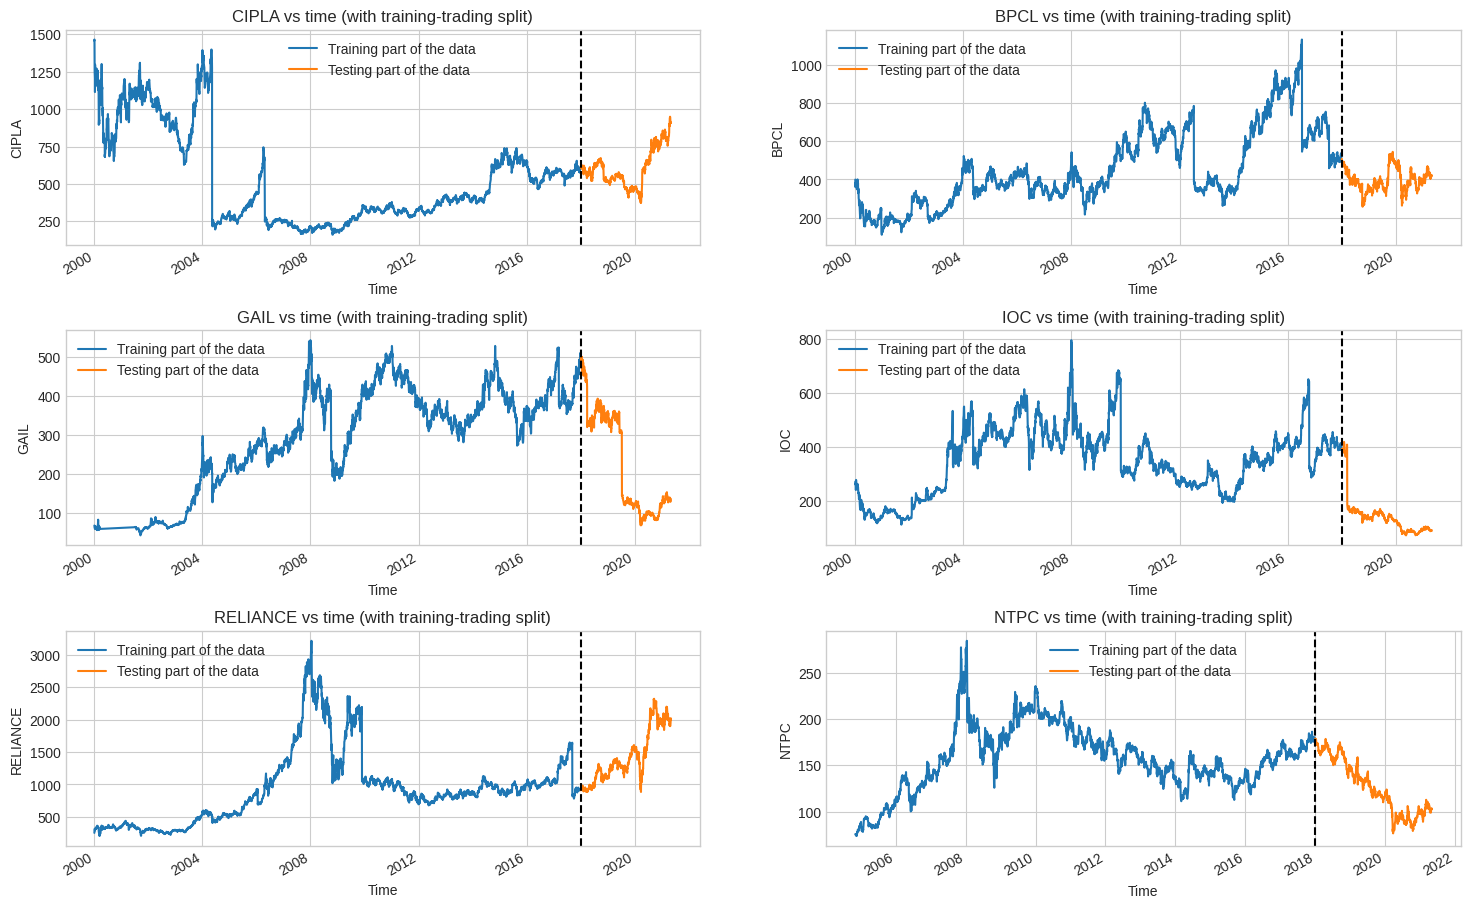

In [ ]:
fig, ax = plt.subplots(8,1, figsize=(18,12))
i=1
for stock in stock_list:
    plt.subplot(3,2,i)
    training_df[stock].plot(label="Training part of the data")
    testing_df[stock].plot(label="Testing part of the data")
    plt.axvline('2018-01-01', color='black', ls='--')
    plt.xlabel('Time')
    plt.ylabel(stock)
    plt.legend()
    plt.title(stock +' vs time (with training-trading split)')
    i=i+1
plt.subplots_adjust(hspace=0.4)

### Scaling the data

#### Neural networks are sensitive to the scale of input features. Large differences in feature scales can lead to instability in training, resulting in vanishing or exploding gradients. Scaling mitigates this issue, making the training process more stable.

In [ ]:
scalers = {}
train_set = {}
test_set = {}

for stock in stock_list:
    scaler = MinMaxScaler()
    scaler.fit(df[stock].values.reshape(-1, 1))
    train_set[stock] = scaler.transform(training_df[stock].values.reshape(-1, 1))
    test_set[stock] = scaler.transform(testing_df[stock].values.reshape(-1, 1))
    scalers[stock] = scaler

#### Preparing the data to feed into the LSTM. We will take the context window of 15 days for modelling.

In [ ]:
# function to create a timseries data
def create_series(data_array):
    LEN_DATA = len(data_array)
    SEQ_LENGTH = 15
    X, Y = [], []

    for i in range(LEN_DATA - SEQ_LENGTH):
        x, y = data_array[i:SEQ_LENGTH + i], data_array[SEQ_LENGTH + i]
        x, y = np.array(x), np.array(y)
        X.append(x); Y.append(y)

    return np.array(X), np.array(Y)

In [ ]:
data_train = {}
data_test = {}

for stock in stock_list:
    X_train, Y_train = create_series(train_set[stock])
    X_test, Y_test = create_series(test_set[stock])

    data_train[stock] = [X_train, Y_train]
    data_test[stock] = [X_test, Y_test]

### Creating and training the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 15, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 15, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

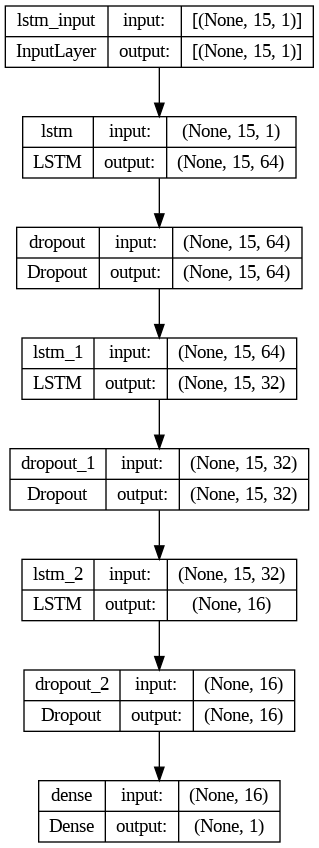

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(64, activation='relu', input_shape=(15, 1), return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss = tf.keras.losses.MeanSquaredError())
model.summary()

from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

In [ ]:
histories = {}
for stock in stock_list:
    print("Training on " + stock)
    history = model.fit(data_train[stock][0], data_train[stock][1], epochs = 8, batch_size = 16, validation_split = 0.2, verbose = True)
    histories[stock] = history

Training on CIPLA
Epoch 1/8
224/224 [==============================] - 10s 29ms/step - loss: 0.0159 - val_loss: 0.0011
Epoch 2/8
224/224 [==============================] - 5s 22ms/step - loss: 0.0071 - val_loss: 8.0025e-04
Epoch 3/8
224/224 [==============================] - 7s 32ms/step - loss: 0.0059 - val_loss: 5.2411e-04
Epoch 4/8
224/224 [==============================] - 5s 22ms/step - loss: 0.0053 - val_loss: 4.7339e-04
Epoch 5/8
224/224 [==============================] - 5s 23ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 6/8
224/224 [==============================] - 6s 25ms/step - loss: 0.0051 - val_loss: 4.3534e-04
Epoch 7/8
224/224 [==============================] - 5s 21ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 8/8
224/224 [==============================] - 6s 27ms/step - loss: 0.0047 - val_loss: 5.3551e-04
Training on BPCL
Epoch 1/8
224/224 [==============================] - 5s 22ms/step - loss: 0.0019 - val_loss: 0.0061
Epoch 2/8
224/224 [=========================

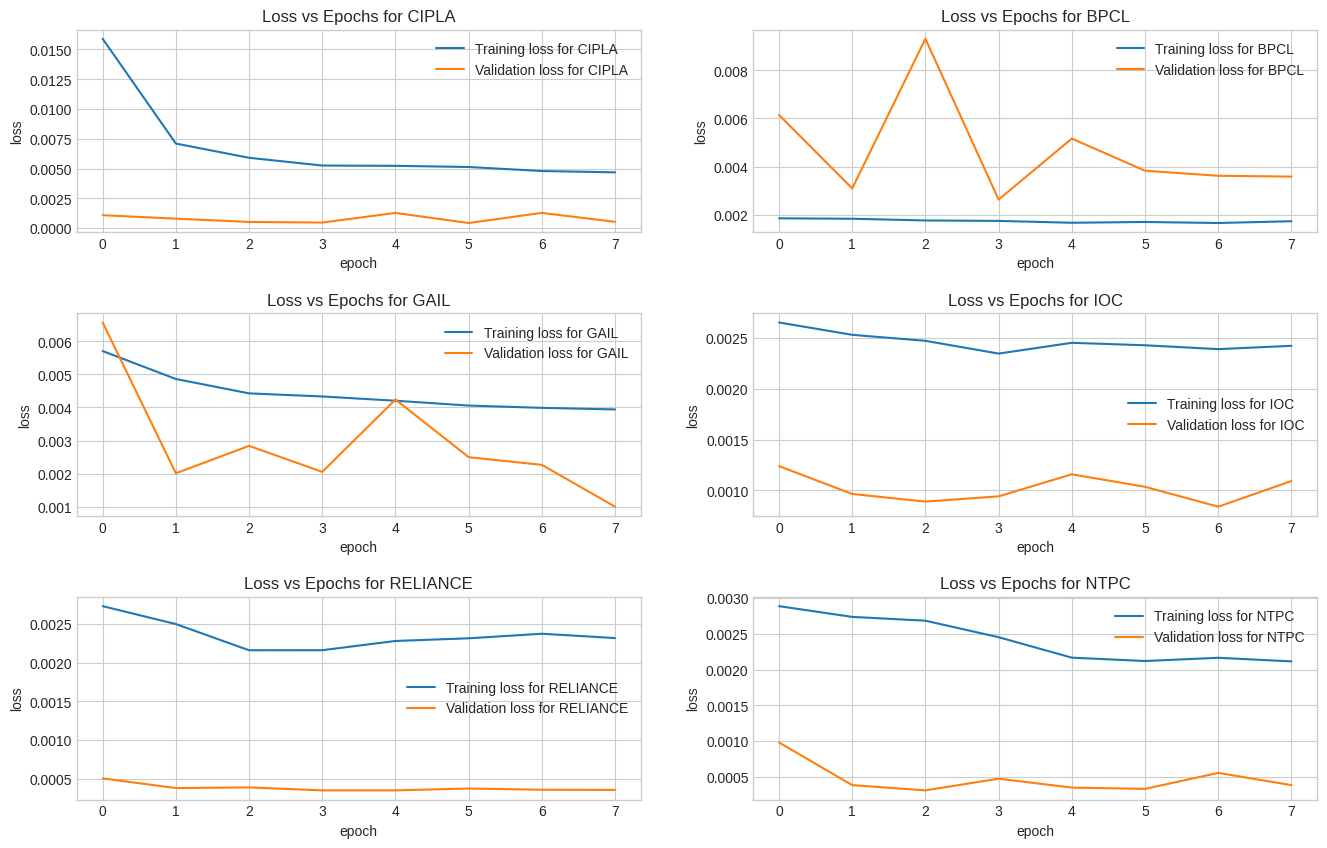

In [ ]:
fig, ax = plt.subplots(8,1, figsize=(16,10))
i=1
for stock in stock_list:
    plt.subplot(3,2,i)
    plt.plot(range(len(histories[stock].history['loss'])), histories[stock].history['loss'], label='Training loss for ' + stock)
    plt.plot(range(len(histories[stock].history['val_loss'])), histories[stock].history['val_loss'], label='Validation loss for ' + stock)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs Epochs for ' + stock)
    plt.legend()
    i=i+1
plt.subplots_adjust(hspace=0.4)

In [ ]:
train_losses = np.array([])
val_losses = np.array([])
for stock in stock_list:
    train_losses = np.concatenate([train_losses, histories[stock].history['loss']])
    val_losses = np.concatenate([val_losses, histories[stock].history['val_loss']])

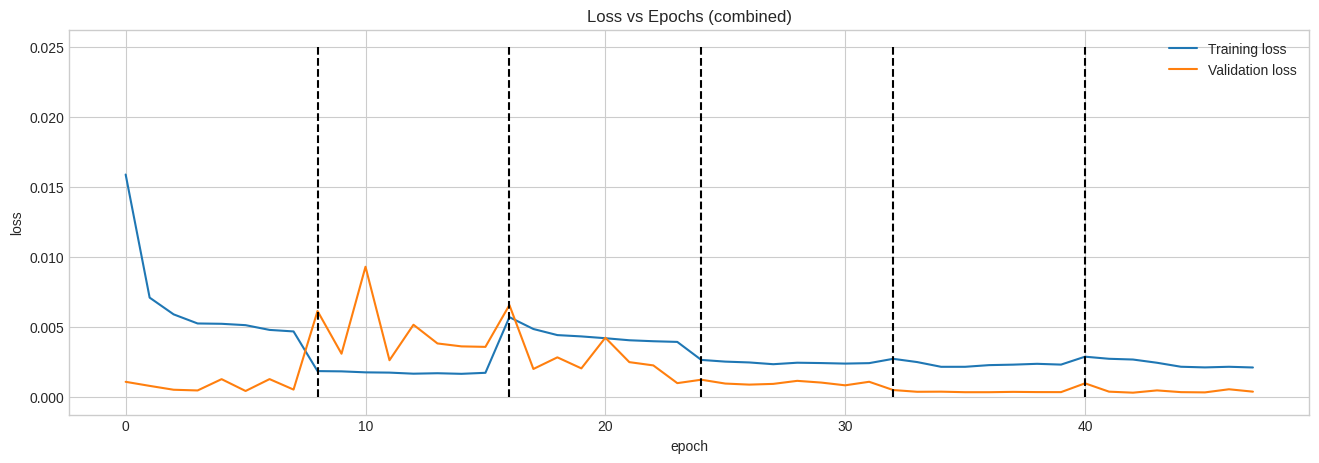

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(train_losses, label = 'Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epochs (combined)')
plt.vlines([8, 16, 24, 32, 40], ymin = 0, ymax = 0.025, colors='black', linestyles='dashed')
plt.legend()
plt.show()

In [ ]:
predictions = {}
for stock in stock_list:
    print("Predicting on " + stock)
    predictions[stock] = model.predict(data_test[stock][0])

Predicting on CIPLA
26/26 [==============================] - 1s 8ms/step
Predicting on BPCL
26/26 [==============================] - 0s 8ms/step
Predicting on GAIL
26/26 [==============================] - 0s 9ms/step
Predicting on IOC
26/26 [==============================] - 0s 8ms/step
Predicting on RELIANCE
26/26 [==============================] - 0s 6ms/step
Predicting on NTPC
26/26 [==============================] - 0s 7ms/step


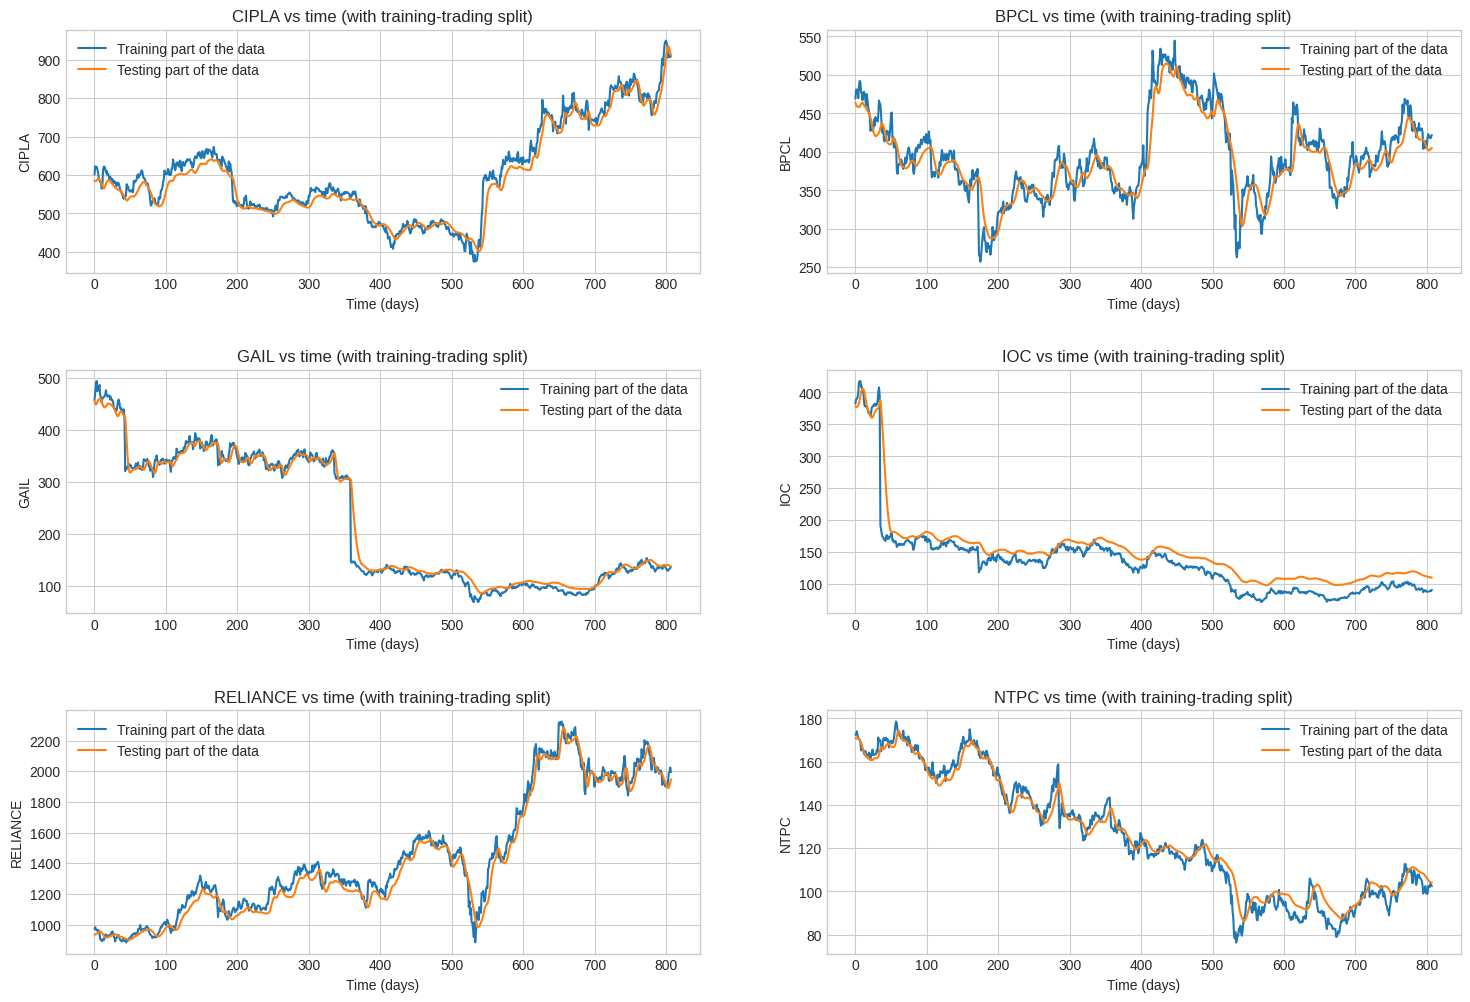

In [ ]:
fig, ax = plt.subplots(8,1, figsize=(18,12))
i=1
for stock in stock_list:
    plt.subplot(3,2,i)
    plt.plot(scalers[stock].inverse_transform(data_test[stock][1]), label="Training part of the data")
    plt.plot(scalers[stock].inverse_transform(predictions[stock]), label="Testing part of the data")
    plt.xlabel('Time (days)')
    plt.ylabel(stock)
    plt.legend()
    plt.title(stock +' vs time (with training-trading split)')
    i=i+1
plt.subplots_adjust(hspace=0.4)